### Get session info
- Data is appended per cell


In [1]:
date = '191012'
dishID = 'dish_1'
cellID = 'cell_1'


In [5]:
# dataPath = '/Volumes/genie/Jihong_GENIE_stuff/Voltron-ST&excitability/'
dataPath = '/Volumes/genie/Jihong_GENIE_stuff/Soma_tag&Neuronal_excitability/Positron-ST&excitability'
# dataPath = '/Users/zhengj10/Desktop/Positron-ST&excitability'
# dataPath = '/Volumes/WS_0917to0818/20190228'


### Import modules

In [6]:
import os
from glob import glob
from pywavesurfer import ws
import sys
sys.path.append('/Users/zhengj10/Python/Modules')
from WC_ephys import *
import numpy as np
import scipy.signal as ss
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from termcolor import colored
import unicodedata
import pandas as pd5

In [7]:
os.path.exists(dataPath)


True

### Locate data files

In [8]:
h5files = glob(os.path.join(dataPath, date, dishID, cellID, '*.h5'))
h5files = sorted(h5files)
# h5files


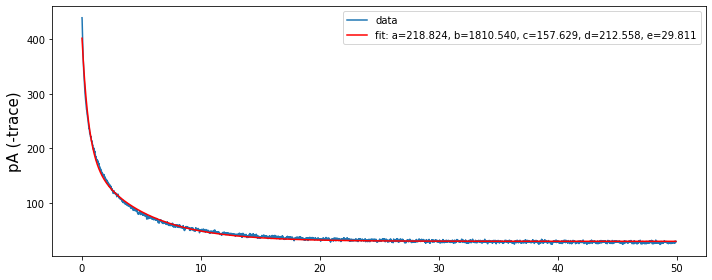

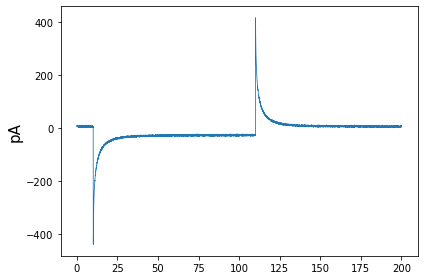

Ra: 22.44 MΩ
Rm: 270.1 MΩ
Cm: 113.15 pF
Sq: 5
tau_f: 0.552 ms
tau_s: 4.705 ms


In [9]:
fig = plt.figure(figsize=(10,4))
for h5data in h5files:
#     print(h5data)
    traces, meta = get_data(h5data)
#     print (meta['trialType'])
#     print meta['sampleRate']
    if meta['trialType'] == b'Mem-test':
        meta_MT = meta
        Ra, Rm, Cm, tau_f, tau_s, leak, seal_quality = mem_test(h5data, Vstep = -10, height = 300) # Height need to be adjusted
        trace = np.mean(traces, axis=0)
        x = (np.arange(1, trace.shape[0]+1))*1000.0/meta['sampleRate']
        plt.plot(x, trace, lw = 0.8)
        plt.ylabel('pA', size = 15)
#         plt.ylim((-200, 200))
        plt.tight_layout()
        plt.show()
#         print ('Ra: %s; Rm: %s; Cm: %s' %(Ra, Rm, Cm))
#         print ('Seal quality: %s' %(seal_quality))
        print (colored('Ra: ', attrs=['bold']) + str(round(Ra, 2)) + ' M' + unicodedata.lookup("GREEK CAPITAL LETTER omega"))
        print (colored('Rm: ', attrs=['bold']) + str(round(Rm, 2)) + ' M' + unicodedata.lookup("GREEK CAPITAL LETTER omega"))
        print (colored('Cm: ', attrs=['bold']) + str(round(Cm, 2)) + ' pF')
        print (colored('Sq: ', attrs=['bold']) + str(seal_quality))
        print (colored('tau_f: ', attrs=['bold']) + str(round(tau_f,3)) + ' ms')
        print (colored('tau_s: ', attrs=['bold']) + str(round(tau_s,3)) + ' ms')


In [ ]:
trace.shape

In [ ]:
# fig = plt.figure(figsize=[10,6])
# plt.plot(x, trace, lw = 0.8)
# plt.ylabel('pA', size = 15)
# #         plt.ylim((-200, 200))
# plt.xlabel('ms', size = 15)
# #         plt.ylim((-200, 200))
# plt.tight_layout()
# plt.show()
# fig.savefig('/Users/zhengj10/Desktop/whole_cell.png')

### Check data
- Spike selection
- Threshold point
- Corrected trace
- Tail length & shape for AHP analysis

In [ ]:
plt.figure(figsize=(12,12))
for h5data in h5files:
    traces, meta = get_data(h5data)
    print (meta['trialType'])
    if meta['trialType'] == b'IC-AP threshold_ramp' or meta['trialType'] == b'IC-AP threshold':
        meta_APT = meta
        trace = traces[0]
#         trace = low_pass(trace)
        time, Ith, Vth = get_threshold(h5data, rate = 10)
        rmp = get_rmp(h5data)
        ax1 = plt.subplot(3,2,1)
        ax1.plot(trace, lw = 0.8, color = 'g')
        ax1.scatter(time, Vth, color = 'm', s = 20)
        ax1.set_ylabel('Raw data')
        ax2 = plt.subplot(3,2,2)
        preSpike = int(0.01*meta['sampleRate'])
        postSpike = int(0.02*meta['sampleRate'])
        ax2.plot(np.arange(time - preSpike, time + postSpike), trace[time - preSpike : time + postSpike], color = 'b', lw = 0.8)
        ax2.scatter(time, Vth, color = 'm', s = 20)
        AP_info = get_AP_params(h5data, height = 0, rate = 10, tail = 0.03)
#         print AP_info.keys()
        ax3 = plt.subplot(3,2,3)
        ax3.plot(AP_info['trace_c'], color = 'g', lw = 0.8)
        ax3.set_ylabel('Corrected data')
        ax4 = plt.subplot(3,2,4)
        ax4.plot(AP_info['trace_for_AP'], color = 'b', lw = 0.8)
plt.show()
        

### AP params visualization

In [ ]:
fig = plt.figure(figsize=(8,6))
plt.plot(AP_info['trace_for_AP'], color = 'g', lw = 2.5)
plt.scatter(AP_info['pre_threshold_seg'] , AP_info['trace_for_AP'][AP_info['pre_threshold_seg']], color = 'm', s = 150)
plt.hlines(AP_info['peak_value'], xmin = 50, xmax = int(0.014*meta['sampleRate']), linestyle = '--', lw = 2.5)
a = int(0.01*meta['sampleRate'])
AP_hw_xmin = AP_info['pre_threshold_seg'] + AP_info['AP_halfWidth'][2][0]
AP_hw_xmax = AP_info['pre_threshold_seg'] + AP_info['AP_halfWidth'][3][0]
plt.hlines(AP_info['AP_halfWidth'][1][0], xmin=AP_hw_xmin, xmax=AP_hw_xmax, linestyle = '--', lw = 2.5)
plt.hlines(AP_info['trace_for_AP'][AP_info['pre_threshold_seg']], xmin = 50, xmax = int(0.014*meta['sampleRate']), linestyle = '--', lw = 2.5)
plt.hlines(AP_info['RMP'], xmin = 0, xmax = 600, linestyle = '--', lw = 2.5)
plt.hlines(AP_info['half_AHP_amp'], xmin = AP_info['hfAHP_start'], xmax = AP_info['hfAHP_end'], linestyle = '--', lw = 2.5)
# plt.axis('off')
plt.show()

# AP_info['AP_halfWidth']
# fig.savefig('/Users/zhengj10/Desktop/181129_dish1_cell3_AP_measurement.png', dpi = 1200)

In [ ]:
# AP_info['AP_halfWidth'][0][0]

### No. of APs evoked by 1s pulse

In [ ]:
plt.figure(figsize=(15,8))
for h5data in h5files:
    traces, meta = get_data(h5data)
    print (meta['trialType'])
    if meta['trialType'] == b'IC-1s pulse at 1x threshold':
        meta_1sP = meta
        trace = traces[0]
        peaks = count_AP(h5data, height = 0, cut=0.125)
        numOfAPs_1x = len(peaks)
        ax = plt.subplot(3,1,1)
        ax.plot(trace, color = 'b', lw=0.5)
#         if i==2:
        ax.plot(peaks, trace[peaks], 'x', color = 'm')
#         ax.set_xlim([14800,15000])

        print ('No. of APs: %d' %numOfAPs_1x)
    if meta['trialType'] == b'IC-1s pulse at 1.5x threshold':
        meta_1sP = meta
        trace = traces[0]
        peaks = count_AP(h5data, height = -10, cut=0.125)
        numOfAPs_1dot5x = len(peaks)
        ax = plt.subplot(3,1,2)
        ax.plot(trace, color = 'b', lw=0.5)
#         if i==2:
        ax.plot(peaks, trace[peaks], 'x', color = 'm')

        print ('No. of APs: %d' %numOfAPs_1dot5x)
    if meta['trialType'] == b'IC-1s pulse at 2x threshold':
        meta_1sP = meta
        trace = traces[0]
        peaks = count_AP(h5data, height = -10, cut=0.125)
        numOfAPs_2x = len(peaks)
        ax = plt.subplot(3,1,3)
        ax.plot(trace, color = 'b', lw=0.5)
#         if i==2:
        ax.plot(peaks, trace[peaks], 'x', color = 'm')

        print ('No. of APs: %d' %numOfAPs_2x)
plt.show()


In [ ]:
# plt.figure(figsize=(15,8))
# for h5data in h5files:
#     print(h5data)
#     traces, meta = get_data(h5data)
#     print (meta['trialType'])
#     if h5data == '/Users/zhengj10/Desktop/191012/dish_2/cell_4/trial_0012.h5':
#         meta_1sP = meta
#         trace = traces[0]
#         peaks = count_AP(h5data, height = 0, cut=0.125)
#         numOfAPs_1x = len(peaks)
#         ax = plt.subplot(3,1,1)
#         ax.plot(trace, color = 'b', lw=0.5)
# #         if i==2:
#         ax.plot(peaks, trace[peaks], 'x', color = 'm')
# #         ax.set_xlim([14800,15000])

#         print ('No. of APs: %d' %numOfAPs_1x)
#     if h5data == '/Users/zhengj10/Desktop/191012/dish_2/cell_4/trial_0013.h5':
#         meta_1sP = meta
#         trace = traces[0]
#         peaks = count_AP(h5data, height = 0, cut=0.125)
#         numOfAPs_1dot5x = len(peaks)
#         ax = plt.subplot(3,1,2)
#         ax.plot(trace, color = 'b', lw=0.5)
# #         if i==2:
#         ax.plot(peaks, trace[peaks], 'x', color = 'm')

#         print ('No. of APs: %d' %numOfAPs_1dot5x)
#     if h5data == '/Users/zhengj10/Desktop/191012/dish_2/cell_4/trial_0014.h5':
#         meta_1sP = meta
#         trace = traces[0]
#         peaks = count_AP(h5data, height = 5, cut=0.125)
#         numOfAPs_2x = len(peaks)
#         ax = plt.subplot(3,1,3)
#         ax.plot(trace, color = 'b', lw=0.5)
# #         if i==2:
#         ax.plot(peaks, trace[peaks], 'x', color = 'm')

#         print ('No. of APs: %d' %numOfAPs_2x)
# plt.show()


### Ouput data

In [ ]:
logFile = os.path.join(dataPath,'log.xlsx')
# logFile = '/Users/zhengj10/Desktop/191012/log.xlsx'
pd.set_option('display.max_columns', 50)
df_log = pd.read_excel(logFile, index_col = 0, converters={'Plasmid': str})
# df_log


In [ ]:
cellType = df_log.loc[(df_log['Date'] == int(date)) & (df_log['Dish'] == dishID) & (df_log['Cell'] == cellID), 'Cell_type'].values[0]
plasmid = df_log.loc[(df_log['Date'] == int(date)) & (df_log['Dish'] == dishID) & (df_log['Cell'] == cellID), 'Plasmid'].values[0]
# plasmid = int(plasmid)
density = df_log.loc[(df_log['Date'] == int(date)) & (df_log['Dish'] == dishID) & (df_log['Cell'] == cellID), 'Density'].values[0]
dateTransfection = df_log.loc[(df_log['Date'] == int(date)) & (df_log['Dish'] == dishID) & (df_log['Cell'] == cellID), 'Date_transfection'].values[0]
dateTransfection = int(dateTransfection)
transfected = df_log.loc[(df_log['Date'] == int(date)) & (df_log['Dish'] == dishID) & (df_log['Cell'] == cellID), 'Transfected'].values[0]
transfected = bool(transfected)
remarks = df_log.loc[(df_log['Date'] == int(date)) & (df_log['Dish'] == dishID) & (df_log['Cell'] == cellID), 'Remarks'].values[0]
print (cellType, plasmid, density, dateTransfection, transfected, remarks)


In [ ]:
sumFile = os.path.join(dataPath, 'summary.xlsx')
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_colwidth', 8)
df = pd.read_excel(sumFile, index_col = 0)
df


In [ ]:
# numOfAPs_1x = ''
# numOfAPs_1dot5x = ''
# numOfAPs_2x = ''

In [ ]:
sessionInfo = {
                u'Date': date,
                u'Dish': dishID,
                u'Cell_type': cellType,
                u'Plasmid': plasmid,
                u'Density': density,
                u'Date_transfection': dateTransfection,
                u'Cell': cellID,
                u'Transfected': transfected,
                u'Leak': leak,
                u'Ra': Ra,
                u'Rm': Rm,
                u'Cm': Cm,
                u'tau_f': tau_f,
                u'tau_s': tau_s,
                u'RMP': AP_info['RMP'],
                u'Ith': Ith,
                u'Vth': Vth,
                u'AP_amplitude': AP_info['AP_amplitude'],
                u'AP_width': AP_info['AP_halfWidth'][0][0] * 1000.0 / meta['sampleRate'],
                u'AHP_amplitude': AP_info['AHP_amplitude'],
                u'AHP_width': AP_info['AHP_halfwidth'],
                u'No_APs_1x': numOfAPs_1x,
                u'No_APs_1.5x': numOfAPs_1dot5x,
                u'No_APs_2x': numOfAPs_2x,
                u'Seal_quality': seal_quality,
                u'uIth': Ith/Cm,
                u'Remarks': remarks
            }

In [ ]:
df_new = pd.DataFrame(sessionInfo, columns = list(df), index = ['i',]) # columns specification keeps the order of columns; index specification makes sure dict keys are the columns 
df = df.append(df_new, ignore_index = True)
df.index = np.arange(1, len(df)+1)
df.to_excel(sumFile)
df


### In case of wrong input

In [ ]:
df = df.drop(df.index[len(df)-3])
# df = df.drop(df.index[9])
df.index = np.arange(1, len(df)+1)
df

In [ ]:
df.to_excel(sumFile)

### Single AP protocol
- Discarded due to lack of AHP evoked by 1 ms pulses

In [ ]:
# plt.figure(figsize=(15,4))
# for h5data in h5files:
#     traces, meta = get_data(h5data)
#     if meta['trialType'] == 'IC-singleAP':
#         trace = traces[0]
# #         AP_info, plotParams = get_AP_shape(h5data)
#         ax1 = plt.subplot(1,3,1)
#         ax1.plot(trace, lw = 0.5, color = 'b')
#         ax2 = plt.subplot(1,3,2)
#         ax2.plot(trace[int(8.5*meta['sampleRate']):int(8.5*meta['sampleRate'])+100], lw = 0.5, color = 'g')
#         ax3 = plt.subplot(1,3,3)
#         ax3.plot(trace[int(9.5*meta['sampleRate']):int(9.5*meta['sampleRate'])+1000], lw = 0.5, color = 'g')
# #         preSpike = int(0.01*meta['sampleRate'])
# #         postSpike = int(0.02*meta['sampleRate'])
# #         ax2.plot(np.arange(time - preSpike, time + postSpike), trace[time - preSpike : time + postSpike], color = 'b', lw = 0.8)
#         plt.show()


In [ ]:
# plt.figure(figsize=(12,3))
# ax = plt.subplot(1,1,1)
# # x = np.arange(1,len(traces[0])+1) / float(meta['sampleRate'])
# ax.plot(traces[0], color = 'b', lw = 0.5)
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
# plt.show()


### Height plotting with plt.plot
- Substitute for plt.hlines() command

In [ ]:
# x = trace
# peaks, _ = ss.find_peaks(x, height=0)
# plt.figure(figsize=[12,4])
# plt.plot(x)
# plt.plot(peaks, x[peaks], "x")
# plt.plot(np.zeros_like(x), "--", color="gray")
# plt.show()


### Extract values from MultiClamp-700B cfg file

In [ ]:
# lines = []
# with open('/Users/zhengj10/Desktop/cell1.txt', 'rt') as cfgFile:
#     for line in cfgFile:
#         lines.append(line)


In [ ]:
# import re
# a = [float(s) for s in re.findall(r'-?\d+\.?\d*', lines[214])]
# a

In [ ]:
# cm = a[0] * 10**(12+a[1])

### Walk through data folders

In [ ]:
# thedir = os.path.join(dataPath, date, dishID, cellID)
# print thedir
# cells = [ name for name in os.listdir(thedir) if os.path.isdir(os.path.join(thedir, name)) ]